
Simulation of vehicles & pedestrians arriving at intersection controlled by traffic light



At time 0, traffic light turned green.

At time 0.03008897950342014, vehicle 1 arrived to a green light and started to turn left.

At time 0.0884183037224439, vehicle 1 arrived to a green light and started to go straight.
At time 0.2684936120156349, vehicle 2 arrived to a green light and started to turn left.

At time 0.2944829006347802, vehicle 2 arrived to a green light and started to go straight.
At time 0.43333333333333335, traffic light turned red.

At time 0.5255765583798067, vehicle 1 arrived and started to turn right.

At time0.7203482505985396, pedestrian 1 arrived and started to wait.
At time 0.7814374335648329, vehicle 3 arrived on traffic island and joined the queue at position 1.

At time 0.7927726158359851, vehicle 3 arrived and joined the queue at position 1.
At time 0.8086323297304585, vehicle 4 arrived and joined the queue at position 2.
At time 0.858875242667793 pedestrian 2 

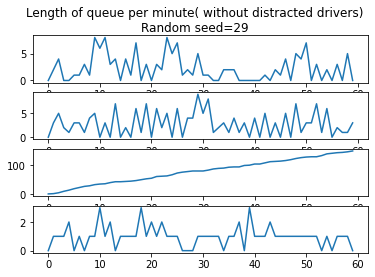

In [281]:
#Triple lane model overview:
#the code block below modeled one side of an intersection 
#(its statistics compared against the second and third blocks which modeled a different situation)
#where vehicles can go straight ahead or turn right on one lane(the right-most lane),
#turn left only on traffic island,
#and only go straight ahead on the lane between the right-most lane and the traffic island.
#At the same time, pedestrians from both sides of the vehicles can cross the road as the traffic light turns green,
#which means red light for the vehicles.
#pedestrians' positions are not taken into account
#pedestrians are assumed to clear the intersection in groups once the traffic light becomes green for them.
#vehicles that arrive on the right-most lane have a 30% chance of making a right turn, 
#and this will slow down the vehicle behind by 2 seconds on average, modeled as a normal(2/60, 1/60) distribution
#the vehicles that enter the traffic island take an average of 30 seconds to clear the intersection,
#modeled as a normal(30/60,10/60) distribution
#the left-turning vehicles arrive at the traffic island according to a Poisson process,
#and the delay it might bring to the vehicles behind is not taken into consideration.
#since the traffic from the opposite side of the intersection was not modeled in this project, 
#the wait time for the left-turn vehicles was simply added upon to the time for them to clear the intersection.
#author: Yusheng Cai

# Import all necessary packages
# double-ended queue
from collections import deque 
import numpy as np
import simpy
from simpy.util import start_delayed
#print right turn in red, left turn in blue
from colorama import Fore, Back, Style 
#tool for output analysis: to calculate confidence interval for sampling distribution
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
%matplotlib inline

#define a utility class to keep track of the statistics
class Stats(object): 
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

#set a random seed to get reproducible results
random_seed = 29
np.random.seed(random_seed)

#pre-define some useful variables
#total number of minutes to be simulated:
end_time = 60

#right-most lane 
#cars arrive at the traffic light according to a Poisson process
#1 cars per 7.91 seconds
t_interarrival_mean = 15.82/60

p_interarrival_mean = 30/60 #interarrival time for pedestrian set to be 30 seconds

island_interarrival_mean = 23.73/60 #interarrival time for left-turning vehicles set to be 30 seconds

straight_interarrival_mean = 15.82/60 

# Traffic light green and red durations:
t_green= 26/60
t_red= 90/60

# The time for a vehicle at the head of the queue to clear the intersection
#(including turn right at red light, turn right at green light, go straight, and turn left) 
#is modeled as four triangular distributions with specified lower bound, mode and upper bound.
#considering normal distribution has negative values which can't be used to model time in simulation,

#turn right at red light
r_t_r_mode = 10/60 
r_t_r_lower = 5/60 
r_t_r_upper = 15/60

#turn right at green light
r_t_mode = 3/60
r_t_lower = 2/60
r_t_upper = 4/60

#go straight 
str_mode = 2/60 
str_lower = 1.8/60
str_upper = 2.2/60

#turn left
l_mode = 30/60
l_lower = 20/60
l_upper = 40/60

#the time for a group of pedestrians to clear the intersection is modeled as a normal distribution
p_crossing_mode = 18/60 
p_crossing_lower = 13/60
p_crossing_upper = 23/60

#initialize queues for the right-most lane, middle lane, traffic island and for the pedestrians
queue = deque()
middle = deque()
island = deque()
pedestrian = deque()

#initialize a list to store number of vehicles/pedestrians in queue, for visualization purposes
right_list = []
middle_list = []
left_list = []
pedestrian_list = []

# initialize the number of vehicles on different lanes and the number of pedestrians
island_count = straight_count = pedestrian_count = arrival_count = departure_count = 0

#stats for the right-most lane
Q_stats= Stats(count=0, cars_waiting=0)
W_stats= Stats(count=0, waiting_time=0.0)

#stats for the pedestrians
P_W_stats = Stats(count=0, waiting_time=0.0)
p_num_stats = Stats(count=0, pedestrian_waiting=0)

#stats for the traffic island
i_w_stats = Stats(count=0, waiting_time=0)
i_num_stats = Stats(count=0, cars_waiting=0)

#stats for the middle lane(go straight only)
s_w_stats = Stats(count=0, waiting_time=0)
s_num_stats = Stats(count=0, cars_waiting=0)

def Straight_arrival(): #arrival event for middle lane 
    global straight_count, env, light, middle

    while True:
        #vehicles arrive on the middle lane to go straight ahead only 
        straight_count += 1
        #if red light or if there is a line on middle lane, join the line
        if light == 'red' or len(middle):
            middle.append((straight_count, env.now))
            print(f"At time {env.now}, vehicle {straight_count} arrived and joined the queue at position {len(middle)}.")

        else:
            print(f"At time {env.now}, vehicle {straight_count} arrived to a green light and started to go straight.")
            s_w_stats.count += 1

        #schedule next arrival
        yield env.timeout(np.random.exponential(straight_interarrival_mean))

def Right_arrival(): #arrival event for the right-most lane 
    global arrival_count, env, light, queue, right_turn_boolean

    while True:
        
        arrival_count+= 1
        right_turn_boolean = np.random.choice([False,True], 1, p=[0.6,0.4])    

        if len(queue):
            queue.append((arrival_count, env.now))
            print(f"At time {env.now}, vehicle {arrival_count} arrived and joined the queue at position {len(queue)}.")
        elif light == 'red':   
            #assume vehicles on the right-most lane turn right with a 30% chance
            if right_turn_boolean:
                print(Fore.RED + f'At time {env.now}, vehicle {arrival_count} arrived and started to turn right.')
                print(Style.RESET_ALL)
                W_stats.count += 1
            else:
                queue.append((arrival_count, env.now))
                print(f"At time {env.now}, vehicle {arrival_count} arrived and joined the queue at position {len(queue)}.")
        elif right_turn_boolean:
            print(Fore.RED + f'At time {env.now}, vehicle {arrival_count} arrived and started to turn right.')
            print(Style.RESET_ALL)
            W_stats.count += 1
        else:
            print(f"At time {env.now}, vehicle {arrival_count} arrived and started to go straight.")
            W_stats.count += 1

      # Schedule next arrival:
        yield env.timeout(np.random.exponential(t_interarrival_mean))

def Island_arrival(): #arrival event for the traffic island
    global island_count, env, light, island

    while True:
        #vehicles arrive on the traffic island only to turn left 
        island_count += 1
        #if red light or if there is a line on the traffic island, join the line
        if light == 'red' or len(island):
            island.append((island_count, env.now))
            print(Fore.BLUE + f"At time {env.now}, vehicle {island_count} arrived on traffic island and joined the queue at position {len(island)}.")
            print(Style.RESET_ALL)
        else:
            print(Fore.BLUE + f"At time {env.now}, vehicle {island_count} arrived to a green light and started to turn left.")
            print(Style.RESET_ALL)
            i_w_stats.count += 1

        #schedule next arrival
        yield env.timeout(np.random.exponential(island_interarrival_mean))


def Right_departure(): #departure event for the right-most lane
    global env, queue

    while True:
        # If the queue is empty, do not schedule the next departure.
        if len(queue) == 0:
            return
        elif right_turn_boolean:
            if light == 'red':
                car_number, t_arrival= queue.popleft()
                print(Fore.RED + f"At time {env.now}, {car_number} turned right at red light, leaving {len(queue)} cars in the queue.")
                print(Style.RESET_ALL)
                W_stats.count += 1
                W_stats.waiting_time += env.now - t_arrival
                yield env.timeout(np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper))
            else:
                car_number, t_arrival= queue.popleft()
                print(Fore.RED +f"At time {env.now}, {car_number} turned right at green light, leaving {len(queue)} cars in the queue.")
                print(Style.RESET_ALL)
                W_stats.count += 1
                W_stats.waiting_time += env.now - t_arrival
                yield env.timeout(np.random.triangular(r_t_lower,r_t_mode,r_t_upper))
        elif light == 'red':
            return
        else: #car in queue and car go straight and light is green     
            car_number, t_arrival= queue.popleft()
            print(f"At time {env.now}, {car_number} departed straight ahead, leaving {len(queue)} cars in the queue.")
            W_stats.count += 1
            W_stats.waiting_time += env.now - t_arrival
            yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper))
                  
def Straight_departure(): #departure event for middle lane where vehicles go straight only
    global env, middle

    while True:
        if light == 'red' or len(middle) == 0:
            return
        else:
            car_number, t_arrival= middle.popleft()
            print(f"At time {env.now}, vehicle {car_number} departed straight ahead, leaving {len(middle)} cars in the queue.")
            s_w_stats.count += 1
            s_w_stats.waiting_time += env.now - t_arrival
            #schedule next departure
            yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper))

def Island_departure(): #departure event for the traffic island where vehicles turn left only
    global env, island

    while True:
        if light == 'red' or len(island) == 0:
            return
        else:
            car_number, t_arrival= island.popleft()
            print(Fore.BLUE + f"At time {env.now}, vehicle {car_number} turned left, leaving {len(island)} cars in the queue.")
            print(Style.RESET_ALL)
            i_w_stats.count += 1
            i_w_stats.waiting_time += env.now - t_arrival
            #schedule next departure:
            yield env.timeout(np.random.triangular(l_lower,l_mode,l_upper))

def Pedestrian():
    
    global env, light, pedestrian, pedestrian_count
    
    while True:
        
        pedestrian_count += 1
        
        if light == 'red' and len(pedestrian): #assume red light for vehicles means green for pedestrians
            print(f'At time {env.now} pedestrian {pedestrian_count} arrived at the intersection and started to cross the road.')
            P_W_stats.count += 1
        else:
            pedestrian.append((pedestrian_count, env.now))
            print(f'At time{env.now}, pedestrian {pedestrian_count} arrived and started to wait.')
        
        yield env.timeout(np.random.exponential(p_interarrival_mean))
    
def pedestrian_cross():
    global env, pedestrian
    
    while True:
        
        pedestrian_idx, t_arrival = [i[0] for i in pedestrian], [i[1] for i in pedestrian]
        P_W_stats.count += len(pedestrian)
        P_W_stats.waiting_time += len(pedestrian)*env.now - sum(t_arrival)
        pedestrian = deque()
        print(f'Pedestrians {pedestrian_idx} crossed the road at time {env.now}.')
        
        if light == 'green' or len(pedestrian)==0: #assume green light for vehicles means red light for pedestrian
            return
        #schedule next crossing
        yield env.timeout(np.random.triangular(p_crossing_lower,p_crossing_mode,p_crossing_upper))

def light():
    
    global env, light

    while True:
        
        light = 'green'
        print(Back.GREEN + Style.BRIGHT + f"At time {env.now}, traffic light turned green.")
        print(Style.RESET_ALL)
        
        #right-most lane
        if len(queue):
            if right_turn_boolean: #turn right
                start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_lower,r_t_mode,r_t_upper))
            else: #go straight
                start_delayed(env, Right_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper))
             
        #middle lane, go straight only
        if len(middle):
            start_delayed(env, Straight_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper))
        
        #traffic island, left turn only          
        if len(island):
            start_delayed(env, Island_departure(), delay=np.random.triangular(l_lower,l_mode,l_upper))
      
        #schedule event that will turn the light red
        yield env.timeout(t_green)

        light = 'red'
        print(Back.RED + Style.BRIGHT +f"At time {env.now}, traffic light turned red.")
        print(Style.RESET_ALL)
        
        if len(pedestrian):
            start_delayed(env,pedestrian_cross(),delay=np.random.triangular(p_crossing_lower,p_crossing_mode,p_crossing_upper))
        
        if len(queue) and right_turn_boolean:
            start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper))

        #schedule event that will turn the light green:
        yield env.timeout(t_red)

#monitor the number of vehicles/pedestrians waiting per minute
def monitor(): 
    global env, Q_stats, p_num_stats, i_num_stats, s_num_stats  
    while True:
                  
        Q_stats.count += 1
        Q_stats.cars_waiting += len(queue)
        right_list.append(len(queue))
                  
        p_num_stats.count += 1
        p_num_stats.pedestrian_waiting += len(pedestrian)
        pedestrian_list.append(len(pedestrian))
                  
        i_num_stats.count += 1
        i_num_stats.cars_waiting += len(island)
        left_list.append(len(island))
        
        s_num_stats.count += 1
        s_num_stats.cars_waiting += len(middle)
        middle_list.append(len(middle))
                  
        #check the number of vehicles on each lane and the number of pedestrians every min
        yield env.timeout(1) 


#schedule initial events and run the simulation

print("\nSimulation of vehicles & pedestrians arriving at intersection controlled by traffic light\n\n\n")

#initialize environment:
env= simpy.Environment()

#schedule the first change of the traffic light:
env.process(light())

#schedule first arrival of vehicle on each lane
start_delayed(env, Right_arrival(), delay=np.random.exponential(t_interarrival_mean))
start_delayed(env, Straight_arrival(), delay=np.random.exponential(straight_interarrival_mean))
start_delayed(env, Island_arrival(), delay=np.random.exponential(island_interarrival_mean))

#schedule first arrival of pedestrian
start_delayed(env, Pedestrian(), delay=np.random.exponential(p_interarrival_mean))

#schedule first statistical monitoring event:
env.process(monitor())

# Let the simulation run for specified time:
env.run(until=end_time)


# Report statistics.

print(f"\n\n      *** Statistical report( random seed={random_seed}) ***")
print('     ( Triple-lane with no distracted drivers)\n')
print('Right-most lane stats:')
print(f"Number of vehicles waiting in right-most lane per minute: {Q_stats.cars_waiting / float(Q_stats.count)}")
print(f"Average wait time for a vehicle on the right-most lane(minutes): {W_stats.waiting_time / float(W_stats.count)}")
print('\nMiddle lane stats:')
print(f"Number of vehicles waiting in middle lane per minute: {s_num_stats.cars_waiting / float(s_num_stats.count)}")
print(f"Average wait time for a vehicle on the middle lane (minutes): {s_w_stats.waiting_time / float(s_w_stats.count)}")
print('\nTraffic island stats:')
print(f"Number of vehicles waiting in traffic island per minute: {i_num_stats.cars_waiting / float(i_num_stats.count)}")
print(f"Average wait time for a vehicle on the traffic island (minutes): {i_w_stats.waiting_time / float(i_w_stats.count)}")
print('\nPedestrians stats:')
print(f"Number of pedestrians waiting to cross per minute: {p_num_stats.pedestrian_waiting / float(p_num_stats.count)}")
print(f"Average wait time for a pedestrian (minutes): {P_W_stats.waiting_time / float(P_W_stats.count)}")

fig, axs = plt.subplots(4)
fig.suptitle(f'Length of queue per minute( without distracted drivers)\nRandom seed={random_seed}')
axs[0].plot(right_list)
axs[1].plot(middle_list)
axs[2].plot(left_list)
axs[3].plot(pedestrian_list)



In [201]:

#num_v_right_lane_per_min = []
#num_v_middle_lane_per_min = []
#num_v_left_lane_per_min = []
#num_p_per_min = []

#avg_wait_right_lane = []
#avg_wait_middle_lane = []
#avg_wait_left_lane = []
#avg_wait_p = []


In [282]:
num_v_right_lane_per_min.append(Q_stats.cars_waiting / float(Q_stats.count))
num_v_middle_lane_per_min.append(s_num_stats.cars_waiting / float(s_num_stats.count))
num_v_left_lane_per_min.append(i_num_stats.cars_waiting / float(i_num_stats.count))
num_p_per_min.append(p_num_stats.pedestrian_waiting / float(p_num_stats.count))

avg_wait_right_lane.append(W_stats.waiting_time / float(W_stats.count))
avg_wait_middle_lane.append(s_w_stats.waiting_time / float(s_w_stats.count))
avg_wait_left_lane.append(i_w_stats.waiting_time / float(i_w_stats.count))
avg_wait_p.append(P_W_stats.waiting_time / float(P_W_stats.count))

In [283]:
num_v_right_lane_per_min

[1.8833333333333333,
 2.933333333333333,
 2.683333333333333,
 2.3,
 2.7666666666666666,
 2.0166666666666666,
 1.9833333333333334,
 2.1333333333333333,
 2.466666666666667,
 2.25,
 1.6166666666666667,
 2.7,
 1.9,
 2.45,
 2.55,
 2.683333333333333,
 1.9666666666666666,
 1.95,
 2.6333333333333333,
 5.65,
 2.4,
 2.35,
 2.3833333333333333,
 2.55,
 1.8166666666666667,
 2.2,
 1.7333333333333334,
 2.45,
 2.05,
 2.25]

In [286]:
#confidence intervals for average queue length per minute and average wait time( minutes)
#for right lane, middle lane, traffic island and pedestrians respectively

print(sms.DescrStatsW(num_v_right_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_v_middle_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_v_left_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_p_per_min).tconfint_mean())

print('\n')

print(sms.DescrStatsW(avg_wait_right_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_middle_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_left_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_p).tconfint_mean())

(2.1281990967456834, 2.651800903254317)
(2.522367607580408, 2.716521281308481)
(67.99357667850691, 73.54753443260421)
(0.9235052954609008, 0.9809391489835438)


(0.5944454100216963, 0.7020571732641843)
(0.6843869391268983, 0.7166608774162025)
(22.29911095889478, 27.08504588203894)
(0.4603907978430318, 0.4898966165719418)


In [ ]:
num_v_right_lane_per_min = [1.8833333333333333,2.933333333333333,]
num_v_middle_lane_per_min = [2.1166666666666667,2.3833333333333333]
num_v_left_lane_per_min = [69.63333333333334,71.8]
num_p_per_min = [1.0166666666666666,0.9333333333333333,]

avg_wait_right_lane = [0.5349022744620654,0.7292202836908427,]
avg_wait_middle_lane = [0.7125319786052909,0.6545563312497986,]
avg_wait_left_lane = [26.124857388699404,14.23689065737379]
avg_wait_p = [0.5183615755927233,0.5184300109186466]

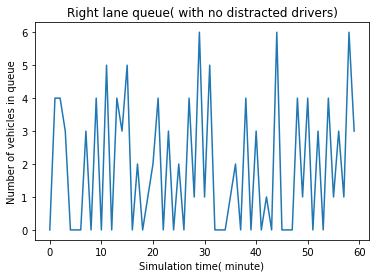

In [181]:
plt.title('Right lane queue( with no distracted drivers)')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(right_list)

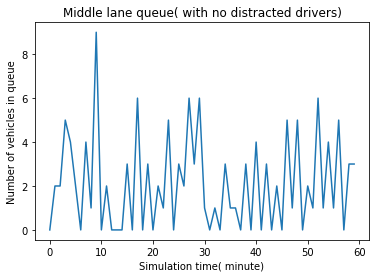

In [182]:
plt.title('Middle lane queue( with no distracted drivers)')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(middle_list)

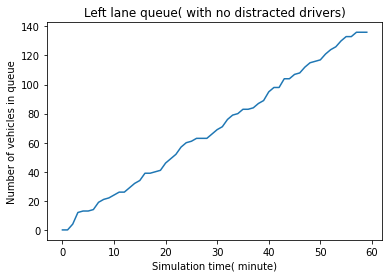

In [183]:
plt.title('Left lane queue( with no distracted drivers)')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(left_list)

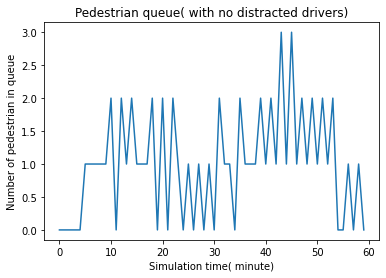

In [184]:
plt.title('Pedestrian queue( with no distracted drivers)')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of pedestrian in queue')
plt.plot(pedestrian_list)


Simulation of vehicles & pedestrians arriving at intersection controlled by traffic light




With 20.0% istracted drivers



At time 0, traffic light turned green.

At time 0.03008897950342014, vehicle 1 arrived to a green light and started to turn left.

At time 0.0884183037224439, vehicle 1 arrived to a green light and started to go straight.
At time 0.33918587487192464, vehicle 2 arrived to a green light and started to turn left.

At time 0.43333333333333335, traffic light turned red.

At time 0.5255765583798067, vehicle 1 arrived and joined the queue at position 1.
At time 0.5867080189236488, vehicle 2 arrived and joined the queue at position 1.
At time 0.6025677328181221, vehicle 3 arrived and joined the queue at position 2.
At time0.7203482505985396, pedestrian 1 arrived and started to wait.
At time 0.741538986174922, vehicle 4 arrived and joined the queue at position 3.
At time 0.8194788092792691, vehicle 5 arrived and joined the queue at position 4.
At time 0.8615060207458966

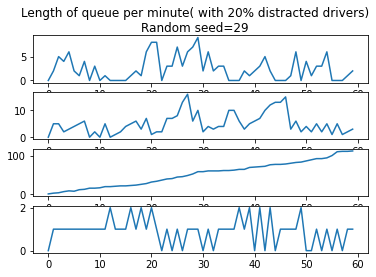

In [359]:
#distracted driving, set a global variable distracted_boolean = np.random.choice([True,False],p=[0.3,0.7])
#based on triple lane model

# Import all necessary packages
# double-ended queue
from collections import deque 
import numpy as np
import simpy
from simpy.util import start_delayed
#print right turn in red, left turn in blue
from colorama import Fore, Back, Style 

#define a utility class to keep track of the statistics
class Stats(object): 
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

#set a random seed to get reproducible results
random_seed = 29
np.random.seed(random_seed)

#pre-define some useful variables
#total number of minutes to be simulated:
end_time = 60

#cars arrive at the traffic light according to a Poisson process with an
#1 cars per 7.91 seconds
t_interarrival_mean = 15.82/60

p_interarrival_mean = 30/60 #interarrival time for pedestrian set to be 30 seconds

island_interarrival_mean = 23.73/60 #interarrival time for left-turning vehicles set to be 30 seconds

straight_interarrival_mean = 15.82/60 

# Traffic light green and red durations:
t_green= 26/60
t_red= 90/60

# The time for a vehicle at the head of the queue to clear the intersection
#(including turn right at red light, turn right at green light, go straight, and turn left) 
#is modeled as four triangular distributions with specified lower bound, mode and upper bound.
#considering normal distribution has negative values which can't be used to model time in simulation,

#turn right at red light
r_t_r_mode = 10/60 
r_t_r_lower = 5/60 
r_t_r_upper = 15/60

#turn right at green light
r_t_mode = 3/60
r_t_lower = 2/60
r_t_upper = 4/60

#go straight 
str_mode = 2/60 
str_lower = 1.8/60
str_upper = 2.2/60

#turn left
l_mode = 30/60
l_lower = 20/60
l_upper = 40/60

#the time for a group of pedestrians to clear the intersection is modeled as a normal distribution
p_crossing_mode = 18/60 
p_crossing_lower = 13/60
p_crossing_upper = 23/60

# Initialize queues for the right-most lane, middle lane, traffic island and for the pedestrians
queue = deque()
middle = deque()
island = deque()
pedestrian = deque()

#initialize a list to store number of vehicles/pedestrians in queue, for visualization purposes
right_list = []
middle_list = []
left_list = []
pedestrian_list = []

# initialize the number of vehicles on different lanes and the number of pedestrians
island_count = straight_count = pedestrian_count = arrival_count = departure_count = 0

#stats for the right-most lane
Q_stats= Stats(count=0, cars_waiting=0)
W_stats= Stats(count=0, waiting_time=0.0)

#stats for the pedestrians
P_W_stats = Stats(count=0, waiting_time=0.0)
p_num_stats = Stats(count=0, pedestrian_waiting=0)

#stats for the traffic island
i_w_stats = Stats(count=0, waiting_time=0)
i_num_stats = Stats(count=0, cars_waiting=0)

#stats for the middle lane(go straight only)
s_w_stats = Stats(count=0, waiting_time=0)
s_num_stats = Stats(count=0, cars_waiting=0)

distracted_p = 0.2

def Straight_arrival(): #arrival event for middle lane 
    
    global straight_count, env, light, middle, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        #vehicles arrive on the middle lane to go straight ahead only 
        straight_count += 1
        #if red light or if there is a line on middle lane, join the line
        if light == 'red' or len(middle):
            middle.append((straight_count, env.now))
            print(f"At time {env.now}, vehicle {straight_count} arrived and joined the queue at position {len(middle)}.")

        else:
            print(f"At time {env.now}, vehicle {straight_count} arrived to a green light and started to go straight.")
            s_w_stats.count += 1
            
        if distracted_boolean:
        #schedule next arrival
            print(Fore.YELLOW + 'Watch out! Distracted driver!')
            print(Style.RESET_ALL)
            yield env.timeout(np.random.exponential(straight_interarrival_mean) + 1)
        else:
            yield env.timeout(np.random.exponential(straight_interarrival_mean))

def Right_arrival(): #arrival event for the right-most lane 
    global arrival_count, env, light, queue, right_turn_boolean, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        
        arrival_count+= 1
        right_turn_boolean = np.random.choice([False,True], 1, p=[0.6,0.4])    

        if len(queue):
            queue.append((arrival_count, env.now))
            print(f"At time {env.now}, vehicle {arrival_count} arrived and joined the queue at position {len(queue)}.")
        elif light == 'red':   
            #assume vehicles on the right-most lane turn right with a 30% chance
            if right_turn_boolean:
                print(Fore.RED + f'At time {env.now}, vehicle {arrival_count} arrived and started to turn right.')
                print(Style.RESET_ALL)
                W_stats.count += 1
            else:
                queue.append((arrival_count, env.now))
                print(f"At time {env.now}, vehicle {arrival_count} arrived and joined the queue at position {len(queue)}.")
        elif right_turn_boolean:
            print(Fore.RED + f'At time {env.now}, vehicle {arrival_count} arrived and started to turn right.')
            print(Style.RESET_ALL)
            W_stats.count += 1
        else:
            print(f"At time {env.now}, vehicle {arrival_count} arrived and started to go straight.")
            W_stats.count += 1

      # Schedule next arrival:
        if distracted_boolean:
            print(Fore.YELLOW + 'Watch out! Distracted driver!')
            print(Style.RESET_ALL)
            yield env.timeout(np.random.exponential(t_interarrival_mean) + 1)
        else:
            yield env.timeout(np.random.exponential(t_interarrival_mean))

def Island_arrival(): #arrival event for the traffic island
    global island_count, env, light, island, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        #vehicles arrive on the traffic island only to turn left 
        island_count += 1
        #if red light or if there is a line on the traffic island, join the line
        if light == 'red' or len(island):
            island.append((island_count, env.now))
            print(Fore.BLUE + f"At time {env.now}, vehicle {island_count} arrived on traffic island and joined the queue at position {len(island)}.")
            print(Style.RESET_ALL)
        else:
            print(Fore.BLUE + f"At time {env.now}, vehicle {island_count} arrived to a green light and started to turn left.")
            print(Style.RESET_ALL)
            i_w_stats.count += 1

        #schedule next arrival
        if distracted_boolean:
            print(Fore.YELLOW + 'Watch out! Distracted driver!')
            print(Style.RESET_ALL)
            yield env.timeout(np.random.exponential(island_interarrival_mean) + 1)
        else:
            yield env.timeout(np.random.exponential(island_interarrival_mean))


def Right_departure(): #departure event for the right-most lane
    global env, queue, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        # If the queue is empty, do not schedule the next departure.
        if len(queue) == 0:
            return
        elif right_turn_boolean:
            if light == 'red':
                car_number, t_arrival= queue.popleft()
                print(Fore.RED + f"At time {env.now}, {car_number} turned right at red light, leaving {len(queue)} cars in the queue.")
                print(Style.RESET_ALL)
                W_stats.count += 1
                W_stats.waiting_time += env.now - t_arrival
                if distracted_boolean:
                    print(Fore.YELLOW + 'Watch out! Distracted driver!')
                    print(Style.RESET_ALL)
                    yield env.timeout(np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper) + 1)
                else:
                    yield env.timeout(np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper))
            else:
                car_number, t_arrival= queue.popleft()
                print(Fore.RED +f"At time {env.now}, {car_number} turned right at green light, leaving {len(queue)} cars in the queue.")
                print(Style.RESET_ALL)
                W_stats.count += 1
                W_stats.waiting_time += env.now - t_arrival
                if distracted_boolean:
                    print(Fore.YELLOW + 'Watch out! Distracted driver!')
                    print(Style.RESET_ALL)
                    yield env.timeout(np.random.triangular(r_t_lower,r_t_mode,r_t_upper) + 1)
                else:
                    yield env.timeout(np.random.triangular(r_t_lower,r_t_mode,r_t_upper))
        elif light == 'red':
            return
        else: #car in queue and car go straight and light is green     
            car_number, t_arrival= queue.popleft()
            print(f"At time {env.now}, {car_number} departed straight ahead, leaving {len(queue)} cars in the queue.")
            W_stats.count += 1
            W_stats.waiting_time += env.now - t_arrival
            if distracted_boolean:
                print(Fore.YELLOW + 'Watch out! Distracted driver!')
                print(Style.RESET_ALL)
                yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper) + 1)
            else:
                yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper))
                  
def Straight_departure(): #departure event for middle lane where vehicles go straight only
    global env, middle, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        if light == 'red' or len(middle) == 0:
            return
        else:
            car_number, t_arrival= middle.popleft()
            print(f"At time {env.now}, vehicle {car_number} departed straight ahead, leaving {len(middle)} cars in the queue.")
            s_w_stats.count += 1
            s_w_stats.waiting_time += env.now - t_arrival
            #schedule next departure
            if distracted_boolean:
                print(Fore.YELLOW + 'Watch out! Distracted driver!')
                print(Style.RESET_ALL)
                yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper) + 1)
            else:
                yield env.timeout(np.random.triangular(str_lower,str_mode,str_upper))

def Island_departure(): #departure event for the traffic island where vehicles turn left only
    global env, island, distracted_boolean
    distracted_boolean = np.random.choice([True,False],p=[distracted_p,1-distracted_p])

    while True:
        if light == 'red' or len(island) == 0:
            return
        else:
            car_number, t_arrival= island.popleft()
            print(Fore.BLUE + f"At time {env.now}, vehicle {car_number} turned left, leaving {len(island)} cars in the queue.")
            print(Style.RESET_ALL)
            i_w_stats.count += 1
            i_w_stats.waiting_time += env.now - t_arrival
            #schedule next departure:
            if distracted_boolean:
                print(Fore.YELLOW + 'Watch out! Distracted driver!')
                print(Style.RESET_ALL)
                yield env.timeout(np.random.triangular(l_lower,l_mode,l_upper) + 1)
            else:
                yield env.timeout(np.random.triangular(l_lower,l_mode,l_upper))

def Pedestrian():
    
    global env, light, pedestrian, pedestrian_count
    
    while True:
        
        pedestrian_count += 1
        
        if light == 'red' and len(pedestrian): #assume red light for vehicles means green for pedestrians
            print(f'At time {env.now} pedestrian {pedestrian_count} arrived at the intersection and started to cross the road.')
            P_W_stats.count += 1
        else:
            pedestrian.append((pedestrian_count, env.now))
            print(f'At time{env.now}, pedestrian {pedestrian_count} arrived and started to wait.')
        
        yield env.timeout(np.random.exponential(p_interarrival_mean))
    
def pedestrian_cross():
    global env, pedestrian
    
    while True:
        
        pedestrian_idx, t_arrival = [i[0] for i in pedestrian], [i[1] for i in pedestrian]
        P_W_stats.count += len(pedestrian)
        P_W_stats.waiting_time += len(pedestrian)*env.now - sum(t_arrival)
        pedestrian = deque()
        print(f'Pedestrians {pedestrian_idx} crossed the road at time {env.now}.')
        
        if light == 'green' or len(pedestrian)==0: #assume green light for vehicles means red light for pedestrian
            return
        #schedule next crossing
        yield env.timeout(np.random.triangular(p_crossing_lower,p_crossing_mode,p_crossing_upper))

def light():
    
    global env, light

    while True:
        
        light = 'green'
        print(Back.GREEN + Style.BRIGHT + f"At time {env.now}, traffic light turned green.")
        print(Style.RESET_ALL)
        
        #right-most lane
        if len(queue):
            if right_turn_boolean: #turn right
                if distracted_boolean:
                    start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_lower,r_t_mode,r_t_upper) + 1)
                else:
                    start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_lower,r_t_mode,r_t_upper))
            else: #go straight
                if distracted_boolean:
                    start_delayed(env, Right_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper) + 1)
                else:
                    start_delayed(env, Right_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper))
             
        #middle lane, go straight only
        if len(middle):
            if distracted_boolean:
                start_delayed(env, Straight_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper) + 1)
            else:
                start_delayed(env, Straight_departure(), delay=np.random.triangular(str_lower,str_mode,str_upper))
        
        #traffic island, left turn only          
        if len(island):
            if distracted_boolean:
                start_delayed(env, Island_departure(), delay=np.random.triangular(l_lower,l_mode,l_upper)+1)
            else:
                start_delayed(env, Island_departure(), delay=np.random.triangular(l_lower,l_mode,l_upper))
      
        #schedule event that will turn the light red
        yield env.timeout(t_green)

        light = 'red'
        print(Back.RED + Style.BRIGHT +f"At time {env.now}, traffic light turned red.")
        print(Style.RESET_ALL)
        
        if len(pedestrian):
            start_delayed(env,pedestrian_cross(),delay=np.random.triangular(p_crossing_lower,p_crossing_mode,p_crossing_upper))
        
        if len(queue) and right_turn_boolean:
            if distracted_boolean:
                start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper) + 1)
            else:
                start_delayed(env, Right_departure(), delay=np.random.triangular(r_t_r_lower,r_t_r_mode,r_t_r_upper))

        #schedule event that will turn the light green:
        yield env.timeout(t_red)

#monitor the number of vehicles/pedestrians waiting per minute
def monitor(): 
    global env, Q_stats, p_num_stats, i_num_stats, s_num_stats  
    while True:
                  
        Q_stats.count += 1
        Q_stats.cars_waiting += len(queue)
        right_list.append(len(queue))
                  
        p_num_stats.count += 1
        p_num_stats.pedestrian_waiting += len(pedestrian)
        pedestrian_list.append(len(pedestrian))
                  
        i_num_stats.count += 1
        i_num_stats.cars_waiting += len(island)
        left_list.append(len(island))
        
        s_num_stats.count += 1
        s_num_stats.cars_waiting += len(middle)
        middle_list.append(len(middle))
                  
        #check the number of vehicles on each lane and the number of pedestrians every min
        yield env.timeout(1) 

#schedule initial events and run the simulation

print("\nSimulation of vehicles & pedestrians arriving at intersection controlled by traffic light\n\n\n")
print(f'\nWith {distracted_p*100}% istracted drivers\n\n\n')

#initialize environment:
env= simpy.Environment()

#schedule the first change of the traffic light:
env.process(light())

#schedule first arrival of vehicle on each lane
start_delayed(env, Right_arrival(), delay=np.random.exponential(t_interarrival_mean))
start_delayed(env, Straight_arrival(), delay=np.random.exponential(straight_interarrival_mean))
start_delayed(env, Island_arrival(), delay=np.random.exponential(island_interarrival_mean))

#schedule first arrival of pedestrian
start_delayed(env, Pedestrian(), delay=np.random.exponential(p_interarrival_mean))

#schedule first statistical monitoring event:
env.process(monitor())

# Let the simulation run for specified time:
env.run(until=end_time)


# Report statistics.

print(f"\n\n      *** Statistical report( random seed={random_seed}) ***")
print(f'            (with {distracted_p*100}% distracted drivers)\n')

print('Right-most lane stats:')
print(f"Number of vehicles waiting in right-most lane per minute: {Q_stats.cars_waiting / float(Q_stats.count)}")
print(f"Average wait time for a vehicle on the right-most lane(minutes): {W_stats.waiting_time / float(W_stats.count)}")
print('\nMiddle lane stats:')
print(f"Number of vehicles waiting in middle lane per minute: {s_num_stats.cars_waiting / float(s_num_stats.count)}")
print(f"Average wait time for a vehicle on the middle lane (minutes): {s_w_stats.waiting_time / float(s_w_stats.count)}")
print('\nTraffic island stats:')
print(f"Number of vehicles waiting in traffic island per minute: {i_num_stats.cars_waiting / float(i_num_stats.count)}")
print(f"Average wait time for a vehicle on the traffic island (minutes): {i_w_stats.waiting_time / float(i_w_stats.count)}")
print('\nPedestrians stats:')
print(f"Number of pedestrians waiting to cross per minute: {p_num_stats.pedestrian_waiting / float(p_num_stats.count)}")
print(f"Average wait time for a pedestrian (minutes): {P_W_stats.waiting_time / float(P_W_stats.count)}")

fig, axs = plt.subplots(4)
fig.suptitle(f'Length of queue per minute( with 20% distracted drivers)\nRandom seed={random_seed}')
axs[0].plot(right_list)
axs[1].plot(middle_list)
axs[2].plot(left_list)
axs[3].plot(pedestrian_list)



In [287]:
#num_v_right_lane_per_min = []
#num_v_middle_lane_per_min = []
#num_v_left_lane_per_min = []
#num_p_per_min = []

#avg_wait_right_lane = []
#avg_wait_middle_lane = []
#avg_wait_left_lane = []
#avg_wait_p = []



In [360]:
num_v_right_lane_per_min.append(Q_stats.cars_waiting / float(Q_stats.count))
num_v_middle_lane_per_min.append(s_num_stats.cars_waiting / float(s_num_stats.count))
num_v_left_lane_per_min.append(i_num_stats.cars_waiting / float(i_num_stats.count))
num_p_per_min.append(p_num_stats.pedestrian_waiting / float(p_num_stats.count))

avg_wait_right_lane.append(W_stats.waiting_time / float(W_stats.count))
avg_wait_middle_lane.append(s_w_stats.waiting_time / float(s_w_stats.count))
avg_wait_left_lane.append(i_w_stats.waiting_time / float(i_w_stats.count))
avg_wait_p.append(P_W_stats.waiting_time / float(P_W_stats.count))

In [361]:
num_v_right_lane_per_min

[2.9166666666666665,
 3.45,
 4.266666666666667,
 2.1333333333333333,
 2.1,
 2.6,
 2.316666666666667,
 2.433333333333333,
 2.683333333333333,
 2.3666666666666667,
 1.7166666666666666,
 2.4833333333333334,
 2.75,
 6.316666666666666,
 3.2666666666666666,
 4.85,
 3.6166666666666667,
 1.9666666666666666,
 3.2,
 2.6666666666666665,
 2.066666666666667,
 2.5,
 2.95,
 2.316666666666667,
 1.6,
 2.566666666666667,
 3.4,
 2.9,
 3.3833333333333333,
 2.5]

In [362]:
#with 20% distracted drivers
#confidence intervals for average queue length per minute and average wait time( minutes)
#for right lane, middle lane, traffic island and pedestrians respectively

print(sms.DescrStatsW(num_v_right_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_v_middle_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_v_left_lane_per_min).tconfint_mean())
print(sms.DescrStatsW(num_p_per_min).tconfint_mean())

print('\n')

print(sms.DescrStatsW(avg_wait_right_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_middle_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_left_lane).tconfint_mean())
print(sms.DescrStatsW(avg_wait_p).tconfint_mean())

(2.5175586550513342, 3.2346635671708874)
(4.70314985660402, 5.5601834767293115)
(51.073551468279376, 58.01644853172061)
(0.9030607978992382, 0.9602725354340951)


(0.9487583980447314, 1.2408168071481798)
(1.7666538754394037, 2.1348289478956346)
(17.697660789077325, 24.019023361757988)
(0.4724884787724529, 0.4993861470466163)


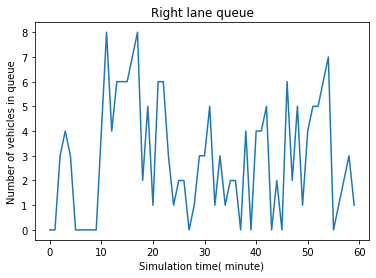

In [174]:
plt.title('Right lane queue')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(right_list)

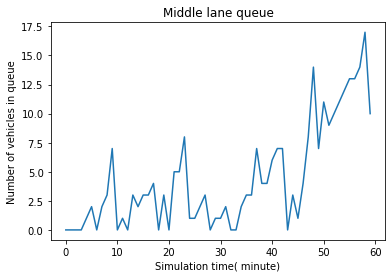

In [175]:
plt.title('Middle lane queue')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(middle_list)

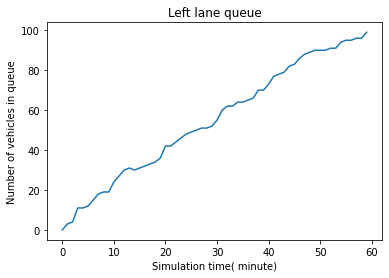

In [176]:
plt.title('Left lane queue')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of vehicles in queue')
plt.plot(left_list)

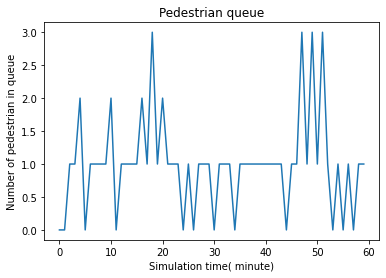

In [177]:
plt.title('Pedestrian queue')
plt.xlabel('Simulation time( minute)')
plt.ylabel('Number of pedestrian in queue')
plt.plot(pedestrian_list)